# Sommaire
- <a href="#C1">Import des librairies
- <a href="#C2">Import des datasets
- <a href="#C3">Première analyse des variables
- <a href="#C31">Remplacement des valeurs colonne is_genuine
- <a href="#C4">Remplacement des valeurs manquantes avec une régression linéaire

# <a name="C1">Import des librairies

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = None # pour afficher toutes les colonnes
pd.options.display.max_rows = None # pour afficher toutes les lignes
# output option format of pandas library changed (to not have exponentials)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np

from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import seaborn as sns

pd.options.display.max_columns = None # pour afficher toutes les colonnes
pd.options.display.max_rows = None # pour afficher toutes les lignes

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *

# <a name="C2">Import et lecture des datasets

In [2]:
billets = pd.read_csv('billets.csv', delimiter=';')

In [31]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81000,104.86000,104.95000,4.52000,2.89000,112.83000
1,1,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000
2,1,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000
3,1,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000
4,1,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000


# <a name="C31"> Remplacement des valeurs colonne is_genuine

In [32]:
billets["is_genuine"] = billets["is_genuine"].astype(int)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81000,104.86000,104.95000,4.52000,2.89000,112.83000
1,1,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000
2,1,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000
3,1,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000
4,1,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000


# <a name="C3">Première analyse des variables

## Taux de données manquantes

In [5]:
tx = (billets.isna().sum()/len(billets))*100
tx

is_genuine     0.00000
diagonal       0.00000
height_left    0.00000
height_right   0.00000
margin_low     2.46667
margin_up      0.00000
length         0.00000
dtype: float64

Les données manquantes sont toutes dans la variable margin_low.

## Nombre de vrais et faux billets

In [6]:
billets['is_genuine'].value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

## Histogrammes

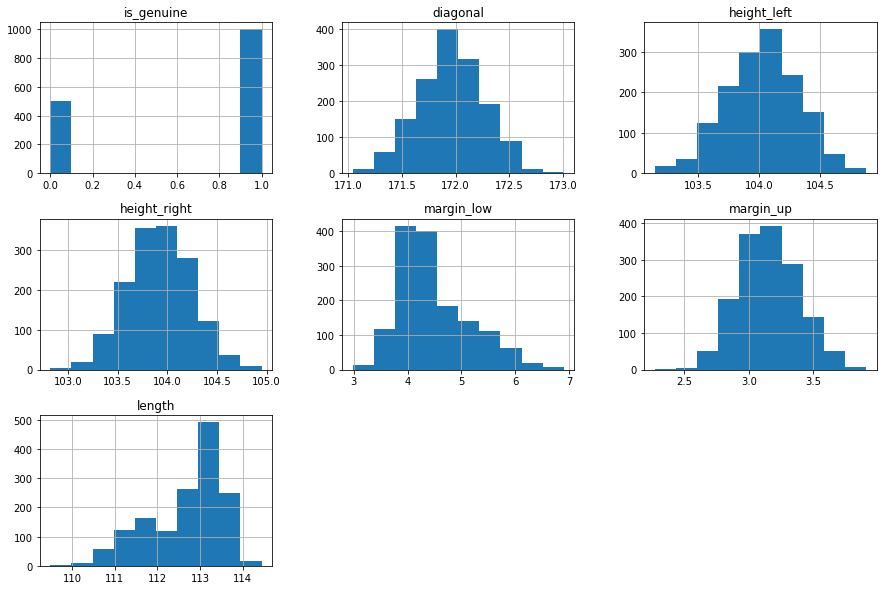

In [7]:
billets.hist(figsize=(15, 10));

Distribution normale, avec une distribution aplatie sur la droite pour margin_low et sur la gauche pour length.

## Statistiques descriptives

In [8]:
billets.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00000,1500.00000,1500.00000,1500.00000,1463.00000,1500.00000,1500.00000
mean,0.66667,171.95844,104.02953,103.92031,4.48597,3.15147,112.67850
std,0.47156,0.30520,0.29946,0.32563,0.66381,0.23181,0.87273
min,0.00000,171.04000,103.14000,102.82000,2.98000,2.27000,109.49000
25%,0.00000,171.75000,103.82000,103.71000,4.01500,2.99000,112.03000
50%,1.00000,171.96000,104.04000,103.92000,4.31000,3.14000,112.96000
75%,1.00000,172.17000,104.23000,104.15000,4.87000,3.31000,113.34000
max,1.00000,173.01000,104.88000,104.95000,6.90000,3.91000,114.44000


## Dispersion des données

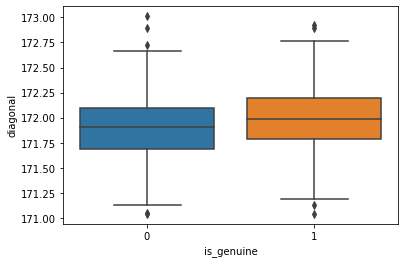

In [9]:
ax = sns.boxplot(x="is_genuine", y="diagonal", data=billets)

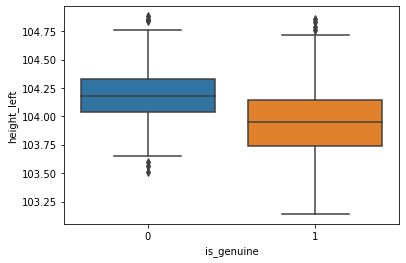

In [10]:
ax = sns.boxplot(x="is_genuine", y="height_left", data=billets)

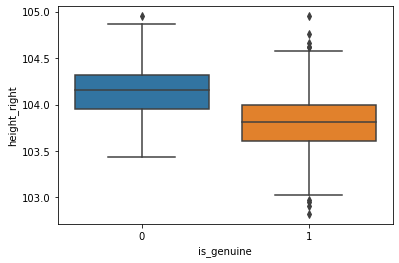

In [11]:
ax = sns.boxplot(x="is_genuine", y="height_right", data=billets)

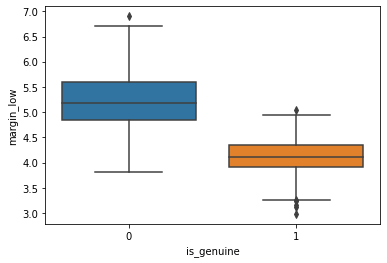

In [12]:
ax = sns.boxplot(x="is_genuine", y="margin_low", data=billets)

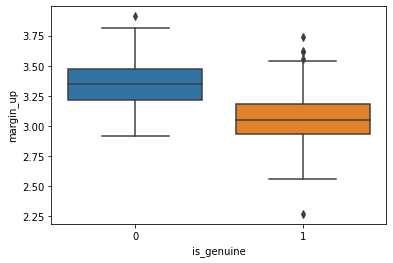

In [13]:
ax = sns.boxplot(x="is_genuine", y="margin_up", data=billets)

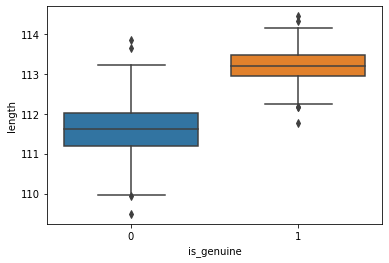

In [14]:
ax = sns.boxplot(x="is_genuine", y="length", data=billets)

## Matrice de corrélation

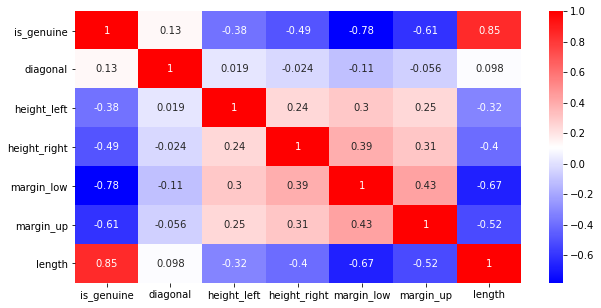

In [15]:
# Calcul de la matrice de corrélation
corr = billets.corr()

# Parématrage de la taille du graphique
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)

# plot the heatmap and annotation on it
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap="bwr")
plt.show()

Is_genuine est fortement corrélé à la longueur du billet et anti-corrélé (entre -0.38 et -0.78 pour margin_low) aux hauteurs et aux marges.

Plus le billet est long plus il a des chances d'être un vrai, plus les hauteurs et les marges sont petites, plus le billet a des chances d'être vrai.

# <a name="C4">Remplacement des valeurs manquantes avec une régression linéaire multiple (backward selection)

On cherche à prédire la valeur de margin_low en fonction des autres variables.

In [16]:
# Isolation des lignes sans valeur manquante
billets1 = billets.dropna()
# Suppression de la colonne is genuine
billets1 = billets1.drop(columns='is_genuine')

In [17]:
# Régression linéaire multiple (backward selection)
reg_backward = backward_selected(billets1, 'margin_low')

_______________________________
margin_low ~ height_right + diagonal + length + margin_up + height_left + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 11 Jul 2022   Prob (F-statistic):          2.60e-202
Time:                        08:34:01   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

### Multi colinéarité
source : https://larmarange.github.io/analyse-R/multicolinearite.html)
Une multicolinéarité prononcée s’avère problématique, car elle peut augmenter la variance des coefficients de régression et les rendre instables et difficiles à interpréter. Les conséquences de coefficients instables peuvent être les suivantes :

- les coefficients peuvent sembler non significatifs, même lorsqu’une relation significative existe entre le prédicteur et la réponse ;
- les coefficients de prédicteurs fortement corrélés varieront considérablement d’un échantillon à un autre ;
- lorsque des termes d’un modèle sont fortement corrélés, la suppression de l’un de ces termes aura une incidence considérable sur les coefficients estimés des autres. Les coefficients des termes fortement corrélés peuvent même présenter le mauvais signe.
##### La multicolinéarité n’a aucune incidence sur l’adéquation de l’ajustement, ni sur la qualité de la prévision. Cependant, les coefficients individuels associés à chaque variable explicative ne peuvent pas être interprétés de façon fiable.

### R-squared = 0.476

In [18]:
# Calcul de la prédiction obtenue
billets1['verif'] = 22.9948-0.1111*billets1['diagonal']+0.1841*billets1['height_left']\
                    +0.2571*billets1['height_right']+0.2562*billets1['margin_up']-0.4091*billets1['length']

In [19]:
# comparaison vraie donnée - prédiction
billets1['comparaison'] = billets1['margin_low']-billets1['verif']

In [20]:
# Description variable comparaison
billets1['comparaison'].describe()

count   1463.00000
mean       0.01288
std        0.47991
min       -1.45945
25%       -0.30419
50%       -0.02880
75%        0.28642
max        1.98371
Name: comparaison, dtype: float64

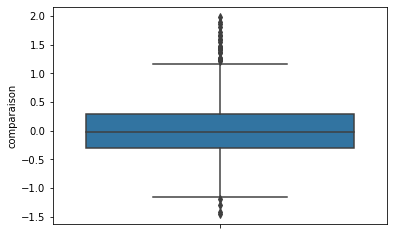

In [21]:
# Dispersion variable comparaison
ax = sns.boxplot(y="comparaison", data=billets1)

In [22]:
# Remplacement des NaN dans le dataset d'origine par la prédiction

# Isolation des lignes avec NaN
nan = billets[billets['margin_low'].isna()]

# remplacement nan par prédiction
nan['margin_low'] = 22.9948-0.1111*nan['diagonal']+0.1841*nan['height_left']\
                    +0.2571*nan['height_right']+0.2562*nan['margin_up']-0.4091*nan['length']

In [23]:
nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94000,103.89000,103.45000,4.30567,3.25000,112.79000
99,1,171.93000,104.07000,104.18000,4.38078,3.14000,113.08000
151,1,172.07000,103.80000,104.38000,4.39756,3.02000,112.93000
197,1,171.45000,103.66000,103.80000,4.30618,3.62000,113.27000
241,1,171.83000,104.14000,104.06000,4.63774,3.02000,112.36000


In [24]:
# Isolation des lignes sans valeur manquante
billets1 = billets.dropna()

In [25]:
# Rajout des lignes avec prédiction sur margin_low dans le dataset
billets2 = billets1.append(nan)

In [26]:
len(billets2)

1500

In [27]:
billets2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81000,104.86000,104.95000,4.52000,2.89000,112.83000
1,1,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000
2,1,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000
3,1,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000
4,1,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000


In [28]:
# Vérification qu'il n'y a plus de NaN
billets2[billets2.isnull().any(axis=1)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [29]:
# Comparaison variable margin_low avant et après imputation des valeurs manquantes


print(billets['margin_low'].describe())
print(billets2['margin_low'].describe())

count   1463.00000
mean       4.48597
std        0.66381
min        2.98000
25%        4.01500
50%        4.31000
75%        4.87000
max        6.90000
Name: margin_low, dtype: float64
count   1500.00000
mean       4.48316
std        0.65968
min        2.98000
25%        4.02000
50%        4.31000
75%        4.87000
max        6.90000
Name: margin_low, dtype: float64


Quasiment pas de changement (ils portaient sur 2.47% des données à remplacer).
- Variation très légère de l'écart-type et de Q1 (premier quartile)

# Export du dataset

In [30]:
billets2.to_csv('billets2.csv',index=False)